# Exoplanet Course Hands-on Session: Transit spectroscopy of WASP-19

### Author: Elsa Ducrot

### This jupyter notebook is a support to the transit hands-on proposed during the PSL exoplanet class directed by Anne-Marie Lagrange and Johan Mazoyer.

*The objective of this hands-on session is to analyse a set of 12 transit light curves of the planet WASP-19 b from different instruments to built its **transmission spectra** and identify some atmopsheric features. To do so we will use data obtained from observations with the Hubble Space Telescope, the Spitzer Space Telescope and the Very Large Telescope. Those data were published in the following paper: [Sing et al. 2015](https://arxiv.org/pdf/1512.04341.pdf).*

*To derive the planet to star radius ratio for each transit light curve we use a toolkit for probabilistic modeling of time series data in astronomy called [`exoplanets`](https://docs.exoplanet.codes/en/latest/). This package uses the analytic model presented in the following paper: [Agol et al. 2020](https://arxiv.org/pdf/1908.03222.pdf). To fit the data an [Hamiltonian Monte Carlo algorithm](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) is used, see the link for details.*

## Imports

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import batman
import numpy  as np
import corner
import os
#os.environ["MKL_THREADING_LAYER"] = "GNU"
import functions_hands_on_transits as TP

## Inputs

### Parameters of the WASP-19 system

you can find/check information on WASP-19 b [here](http://exoplanet.eu/catalog/WASP-19_b/)

Below are the initial parameters, you will have to modify the following ones for each light curve:<font color=teal >  
* `params.u`  
* `filename`




The next cell summurizes the parameters of the planets obtained from the literature 

In [140]:
# ! Do not modify this cell !
params = batman.TransitParams()
params.t0 = 0.  # time of inferior conjunction
params.per = 0.788839  # orbital period
params.rp = 0.14247  # planet radius (in units of stellar radii)
params.a = 3.5338  # semi-major axis (in units of stellar radii)
params.inc = 78.78  # orbital inclination (in degrees)
params.ecc = 0.0046  # eccentricity
params.w = 3.  # longitude of periastron (in degrees)
params.limb_dark = "quadratic"  # limb darkening model


<div class="alert alert-block alert-warning">
<b>Warning:</b> The next cell has to be modified for each light curve.
</div>


In [188]:
params.u = [0.21,0.23]  # limb darkening coefficients [u1, u2]
filename = './light_curves_files/HST_1-537.csv' # filename of the light curve

Here is a figure that briefly explains what the limb-darkening effect is:

<img src="LD_illustration.png" style="height: 400px; width:800px;"/>

And here is a figure showing the effect it has on the transit shape:

<img src="effect_LD_on_transit.png" style="height: 400px; width:600px;"/>

## Read the data

First we create a [`pandas`](https://pypi.org/project/pandas/) dataframe with times, fluxes and fluxes errors:

In [189]:
df_lc = pd.read_csv(filename,sep=',')
df_lc = df_lc.sort_values(by=['Time (days)'])

Let's look at what the light curve looks like, ploting relative flux versus time

Text(0.5, 1.0, 'Light curve ./light_curves_files/HST_1-537.csv')

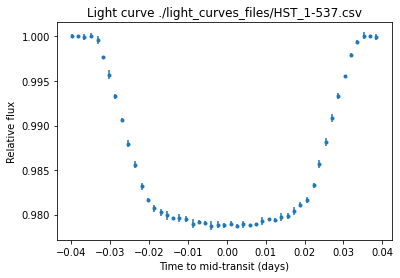

In [190]:
# Raw light curve
df_lc[' Flux error'] = np.random.uniform(low=0.0001, high=0.0005,size=len(df_lc))
plt.errorbar(df_lc['Time (days)'],df_lc[' Flux'],yerr=df_lc[' Flux error'],fmt='.')
plt.xlabel("Time to mid-transit (days)")
plt.ylabel('Relative flux')
plt.title('Light curve ' +filename)

## Fitting data

### Starting point

<div class="alert alert-block alert-info">
<b>Info:</b> The jump parameters here are: the mid-transit time (t0s), the period (periods), the radius ratio (rps) and the semi-major axis (a_ps)
</div>

In [191]:
# Make sure that the data type is consistent
x = np.ascontiguousarray(df_lc['Time (days)'], dtype=np.float64)
y = np.ascontiguousarray(df_lc[' Flux'], dtype=np.float64)
yerr = np.ascontiguousarray(df_lc[' Flux error'], dtype=np.float64)
texp = np.median(np.diff(x))

model, map_estimate = TP.build_model(x,y,yerr,u_s=params.u,t0s=params.t0,periods=params.per,rps=params.rp,a_ps=params.a,texp=texp)


optimizing logp for variables: [log_dQ, log_Q0, log_prot, f, sigma_rot]


message: Optimization terminated successfully.
logp: 260.64412768019497 -> 291.2918454848346
optimizing logp for variables: [log_depth, b, r_star, mean, logP, a, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 291.2918454848349 -> 301.58191022071225
optimizing logp for variables: [f, log_dQ, log_Q0, log_prot, sigma_rot, log_jitter, log_depth, logP, t0, b, a, u_star, r_star, logg_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 301.58191022071225 -> 317.4916499460111


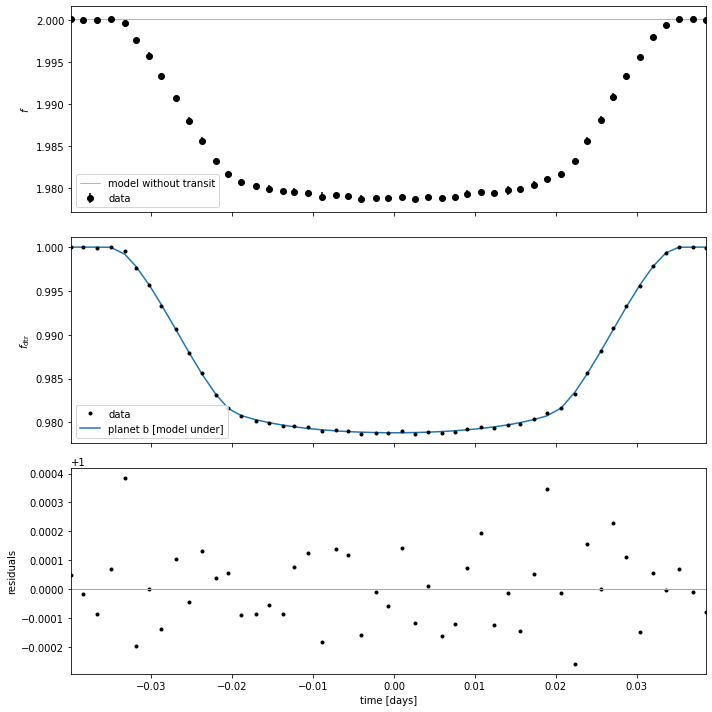

In [192]:
TP.plot_light_curve(x, y, yerr, map_estimate)

### Sampling

<div class="alert alert-block alert-warning">
<b>Warning:</b> This step can take 3 to 5 min. </div>


In [193]:
trace = TP.run_sampling(model,map_estimate)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
/home/localuser/Documents/M2_AstroParis2021/Exoplanets/exoplanet_transit_env/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, log_dQ, log_Q0, log_prot, sigma_rot, log_jitter, log_depth, logP, t0, b, a, u_star, r_star, logg_star, mean]
INFO:pymc3:NUTS: [f, log_dQ, log_Q0, log_prot, sigma_rot, log_jitter, log_depth, logP, t0, b, a, u_star, r_star, logg_star, mean]


Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 52 seconds.
INFO:pymc3:Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 52 seconds.
The acceptance probability does not match the target. It is 0.9989341852561673, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9993805275710501, but should be close to 0.95. Try to increase the number of tuning steps.


### Outputs

Plot the corner plot of your jump parameter to check that the fit has converged

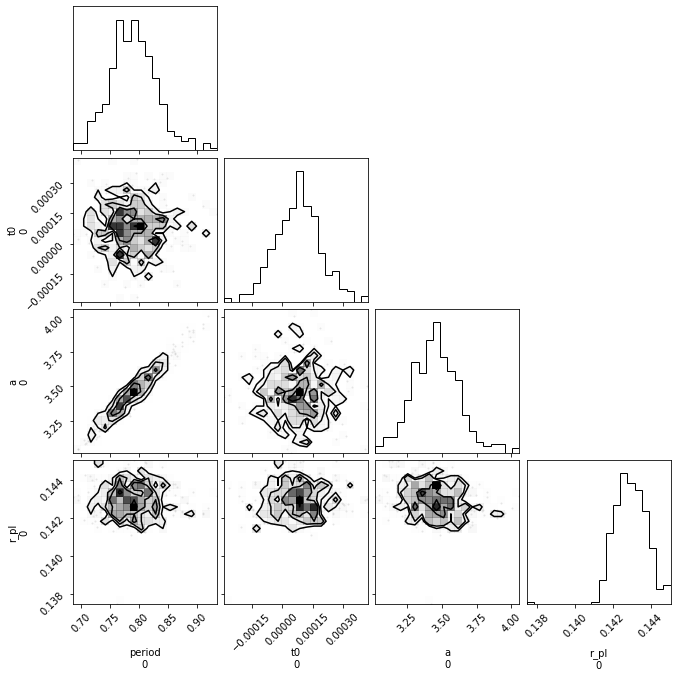

In [194]:
_ = corner.corner(trace, var_names=["period","t0","a","r_pl"])


Now let's plot the data overploted with the transit best fit model

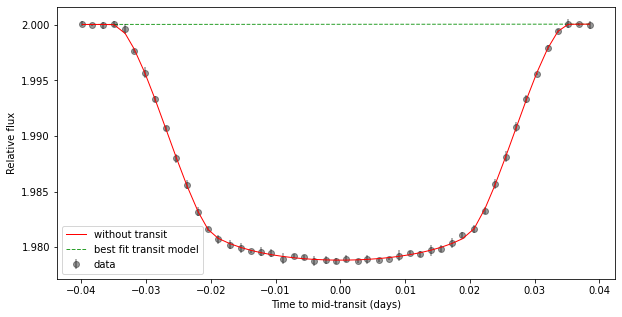

In [195]:
TP.plot_best_fit(x, y, yerr, map_estimate)

Let's display a table with the parameters values output by the MCMC

In [196]:
TP.output_table(trace,var_names=["r_pl"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_pl[0],0.14293,0.00085,0.14146,0.14432,0.00004,0.00003,468.8855,336.16073,1.01394


Now please fill in the `observation_student.txt` file with the mean value + error that you have obtained for the radius of the planet at each wavelength

## Transmission spectrum

This section should be ran only when you have obtained the planet radii from each light curve

Now you will construct the transmission spectra of the planet and compare it to an atmospheric model published in [Sing et al. 2015](https://www.nature.com/articles/nature16068)

In [201]:
model = pd.read_csv('WASP-19b_model_atmosphere.txt', delimiter=',',skiprows=3) # the best fit model from Sing et al. 2015 
observations = pd.read_csv('observations_student.txt', delimiter=',') # your observations

In [205]:
observations["R/R*"]

0     0.14172
1     0.13812
2     0.14236
3     0.14100
4     0.14045
5     0.14043
6     0.14027
7     0.14186
8     0.14293
9     0.13938
10    0.14041
11    0.14323
Name: R/R*, dtype: float64

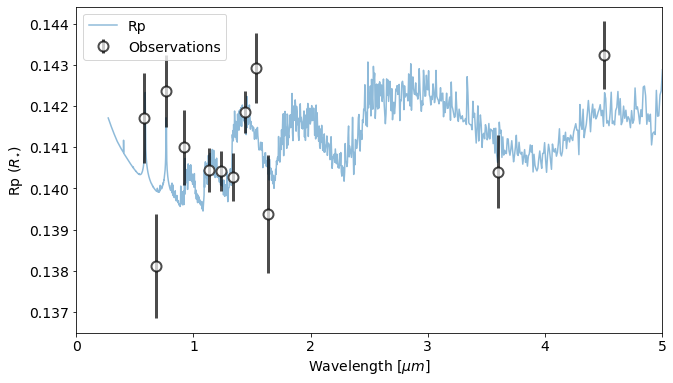

In [206]:
fig, ax = plt.subplots(figsize = (10.5,6))

plt.plot(observations['Wavelength (microns)'],observations['R/R*'],'o',markersize=10,zorder=2,color='white')
plt.plot(model['Wavelength (microns)'], (model['Rp/R*']+0.0005),linewidth=1.5,zorder=1,alpha=0.5,label=r'Rp')
plt.errorbar(observations['Wavelength (microns)'], observations['R/R*'], yerr = observations['errR/R*'],\
             fmt='o',mfc='white',color='black',ecolor='black',markersize='10',markeredgewidth=2,elinewidth=3,alpha=0.7,label='Observations')

ax.tick_params(axis="x", labelsize=14, labelcolor="k")
ax.tick_params(axis="y", labelsize=14, labelcolor="k")
plt.ylabel(r'Rp ($R_{\star})$ ',fontsize=14)
plt.xlabel(r'Wavelength [$\mu m$]',fontsize=14)
ax.set_xlim([0,5])
plt.legend(loc=2, prop={'size': 14})
plt.show()

## Idendify atmospheric features

<font color=teal > **Have fun with those two websites to identify some molecules present in the planet's atmosphere:** 

* [Towards the Planetary Spectrum Generator](https://psg.gsfc.nasa.gov/index.php)


* [Towards the Virtual Planetary Lab Molecular Spectral Engine](http://vplapps.astro.washington.edu/vplrangemicro.php)

## Acknowledgements

This notebook makes great use of the [`exoplanet`](https://docs.exoplanet.codes/en/latest/) package 

In [113]:
TP.acknowledgment()

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{exoplanet:agol20,
exoplanet:arviz, exoplanet:astropy13, exoplanet:astropy18, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.
